# Parameter Fit as a Function of SNR - Code Description

This code serves to study how changing the SNR in data influences the nonlinear least squares (NLLS) estimation of parameter values

We are expecting to see an order of convergence for the estimated data to the real data for a model based on how much noise is added to the data

The principle contributor to this code is Griffin Hampton (GSH)

# Import Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Options

In [2]:
#Initial Options
histPlot = False
histPlotDiff = True     #Looks at the difference between the estimated parameter and the true parameter value
denPlot = False      #Plot all estimated signals against the true signal 

# Initialize Parameters and Arrays

In [3]:
#Assumed echo time points
TE_series = np.arange(8, 512, 8) #ms units

#Set value of TI
TI = 650

######All Fixed parameters
#Biexponential Parameters
c1 = 0.3
c2 = 0.7
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

TI1star = np.log(2)*(T11)
TI2star = np.log(2)*(T12)

#Linear Comparison Parameters
a = 0.3
b = 0.7

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

#Parameters that dictate process related features
iterCount = 50000 #number of iterations that curveFit is applied

#List of SNR power values to process data on
SNR_ub = 4
SNR_lb = 1
SNR_numPoints = 50
SNR_array = 10**np.linspace(SNR_lb, SNR_ub, SNR_numPoints)

#Initializing all the storage matrices
#Storing all strings associated with titles
LinTitle = ['a', 'b']
ParamTitle_4p = ['d1', 'd2', 'T21', 'T22']
ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']

#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(SNR_array), iterCount, np.size(ParamTitle_4p)])
paramStore_lin = np.zeros([np.size(SNR_array), iterCount, np.size(LinTitle)])

#Storing all the estimated signals for each iteration and TI array
sigStore_2E = np.zeros([np.size(SNR_array), iterCount, np.size(TE_series)])
sigStore_lin = np.zeros([np.size(SNR_array), iterCount, np.size(TE_series)])

#All error related matrices
RSS_Store = np.zeros([np.size(SNR_array),iterCount])
L2Store = np.zeros([np.size(SNR_array),iterCount])

RSS_Store_lin = np.zeros([np.size(SNR_array),iterCount])
L2Store_lin = np.zeros([np.size(SNR_array),iterCount])

#Condition number related matrix
CNStore = np.zeros([np.size(SNR_array), iterCount, np.size(ParamTitle_4p)])
avgCNStore = np.zeros([np.size(SNR_array), np.size(ParamTitle_4p)])

#Count Rulebreakers
numRuleBreak = np.zeros(SNR_numPoints)

# Define Functions

In [4]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def lin_model(TE, a, b):
    return a*TE + b

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

# Select Model to Evaluate

In [5]:
#Setting the model and true data to fit to

# model = lambda TE,p1,p2,p3,p4 : S_biX_4p(TE,p1,p2,p3,p4)

true_d1 = d_value(TI, c1, T11)
true_d2 = d_value(TI, c2, T12)

# realParams = np.array([true_d1, true_d2, T21, T22])
realParams = np.array([c1, c2, T21, T22])

initParams = np.array([c1, c2, T21, T22])

trueDat = S_biX_4p(TE_series, *realParams)

init_params = realParams

linParams = np.array([a, b])
linDat = lin_model(TE_series, *linParams)

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_4p)


#Title String
details = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\nSNR Power Range (' + str(SNR_lb) + "," + str(SNR_ub) +
            '):: Points: ' + str(np.size(SNR_array)))


# Curve Fitting Iterations

In [6]:
#Looping through all TI values in the TI_array
for s in trange(np.size(SNR_array)):

    SNR = SNR_array[s]
    noiseSig_Signal = np.max(trueDat)/SNR
    noiseSig_Linear = np.max(linDat)/SNR
    
    numBroke = 0 #Counts the number of times that the exceptions are thrown

    i = 0
    #while loop so that if a lowest parameter value isn't found then we just do it again
    while i < iterCount:

        #Determining the noise and add noise to data
        noise_S = np.random.normal(0, noiseSig_Signal, TE_series.size)
        noise_L = np.random.normal(0, noiseSig_Linear, TE_series.size)
        noise_SDat = trueDat + noise_S
        noise_linDat = linDat + noise_L
        
        lb = (-1,-1,0,0)
        ub = (1,1,T2_bound,T2_bound)
        init_p = realParams

        lb_lin = (-1,0)
        ub_lin = (1,T2_bound)
        init_p_lin = linParams

        try:
            popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noise_SDat, p0 = init_p, bounds = [lb,ub])

            popt_lin, pcov_lin = curve_fit(lambda t_dat,a,b : lin_model(t_dat,a,b), TE_series, noise_linDat, p0 = init_p_lin, bounds = [lb_lin,ub_lin])

        except Exception as e:
            print(e)
            numBroke += 1
            print("Rerunning this iteration = " + str(i))
            continue

        #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place
        if (popt_2E[3] < popt_2E[2]):
            p_hold = popt_2E[0]
            popt_2E[0] = popt_2E[1]
            popt_2E[1] = p_hold
            p_hold = popt_2E[2]
            popt_2E[2] = popt_2E[3]
            popt_2E[3] = p_hold

        paramStore_2E[s,i,:] = popt_2E
        paramStore_lin[s,i,:] = popt_lin

        #Calculate Condition Number
        B = Jacobian_4p(TE_series, *popt_2E) 
        covP = np.dot(B.T,B) #*noiseSigma**2

        CN_params = np.reshape(np.diag(covP),(1,-1))
        CNStore[s,i,:] = CN_params

        #Calculate Residual Sum of Squares (RSS) of 2E
        est_Sig = S_biX_4p(TE_series,*popt_2E)
        RSS_Store[s,i] = np.sum((trueDat - est_Sig)**2)
        L2Store[s,i] = np.linalg.norm(trueDat - est_Sig, ord = 2)
        sigStore_2E[s,i,:] = est_Sig

        #Calculate Residual Sum of Squares (RSS) of 2E
        est_Sig_lin = lin_model(TE_series,*popt_lin)
        RSS_Store_lin[s,i] = np.sum((linDat - est_Sig_lin)**2)
        L2Store_lin[s,i] = np.linalg.norm(linDat - est_Sig_lin, ord = 2)
        sigStore_lin[s,i,:] = est_Sig_lin

        i += 1 #iteration step

    numRuleBreak[s] = numBroke
    # avgCNStore[k,:] = np.reshape(np.mean(CNStore[k,:,:], axis = 0),(1,-1))
    # avgPStore[k,:] = np.mean(paramStore_2E[k,:,:], axis = 0)
    # stdStore[k,:] = np.std(paramStore_2E[k,:,:], axis = 0)
    # std2Store[k,:] = np.var(paramStore_2E[k,:,:], axis = 0)**(1/2)
    # mono_std[k,:] = np.std(paramStore_1E[k,:,:], axis = 0)



  0%|          | 0/50 [00:00<?, ?it/s]

# Plotting

### Histograms - Each SNR Distribution

In [ ]:
if histPlot:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:]
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Parameter Histogram" + details)
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii], bins=20, color='b', label = ParamTitle_4p[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = ParamTitle_4p[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + ParamTitle_4p[2*ii], color='b')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' + ParamTitle_4p[2*ii+1], color='g')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + ParamTitle_4p[2*ii], color='b', stl = "--")
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + ParamTitle_4p[2*ii+1], color='g', stl = "--")
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\nSNR = '+ str(SNR_array[k]) +
                        '\nTrue ' + ParamTitle_4p[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + ParamTitle_4p[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        plt.show()

In [ ]:
if histPlotDiff:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:]
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Difference Parameter Histogram" + details)
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii] - realParams[2*ii], bins=20, color='b', label = "Diff" + ParamTitle_4p[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1] - realParams[2*ii+1], bins=20, color='g', label = "Diff" + ParamTitle_4p[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Difference Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]- realParams[2*ii]), linewidth=1, label= 'Avg diff ' + ParamTitle_4p[2*ii], color='b')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]- realParams[2*ii+1]), linewidth=1, label= 'Avg diff ' + ParamTitle_4p[2*ii+1], color='g')
            ax[ii].legend()
            ax[ii].set_title('Parameter Difference Histogram Comparison' + 
                        '\nSNR = '+ str(SNR_array[k]) +
                        '\nDifference ' + ParamTitle_4p[2*ii] + '=' + str(round(np.mean(paramData[:,2*ii]- realParams[2*ii]),2)) + ' :: ' 
                        'Difference ' + ParamTitle_4p[2*ii+1] + '=' + str(round(np.mean(paramData[:,2*ii+1]- realParams[2*ii+1]),2)))
        plt.show()

NameError: name 'histPlotDiff' is not defined

### Density Plots - Each SNR Distribution

In [ ]:
if denPlot:

    for k in range(paramStore_2E.shape[0]):
        fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + details + '\nSNR = '+ str(SNR_array[k]))
        
        for rep in range(iterCount):
            ax[0,0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[0,1].plot(TE_series, sigStore_lin[k,rep,:], color='r', alpha = 0.5)

        ax[0,0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        ax[0,1].plot(TE_series, linDat, label = "True Data", color='k', alpha = 1)

        ax[0,0].set_xlabel("TE")
        ax[0,1].set_xlabel("TE")
        ax[0,0].set_ylabel("Signal")
        ax[0,1].set_ylabel("Signal")
        ax[0,0].set_title("Biexponential Fits")
        ax[0,1].set_title("Linear Fits")

        ax[1,0].hist(x = (sigStore_2E[k,:,:] - trueDat), bins = 20)
        ax[1,1].hist(x = (sigStore_lin[k,:,:] - linDat), bins = 20)

        ax[1,0].set_xlabel("Error")
        ax[1,1].set_xlabel("Error")
        ax[1,0].set_ylabel("Counts")
        ax[1,1].set_ylabel("Counts")
        ax[1,0].set_title("Biexponential Fits")
        ax[1,1].set_title("Linear Fits")

        plt.show()

### Loglog Plots

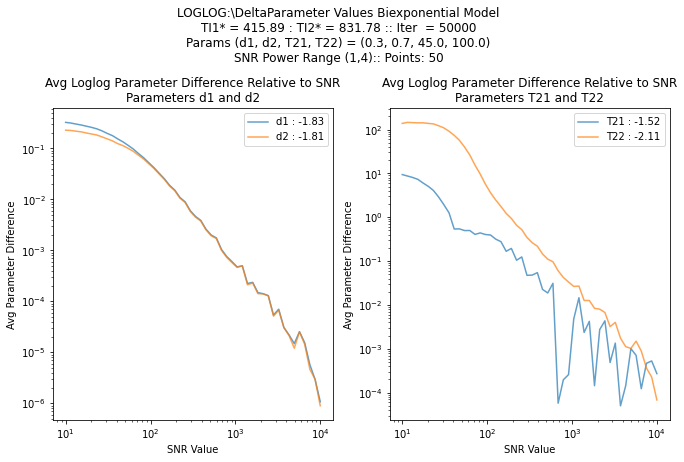

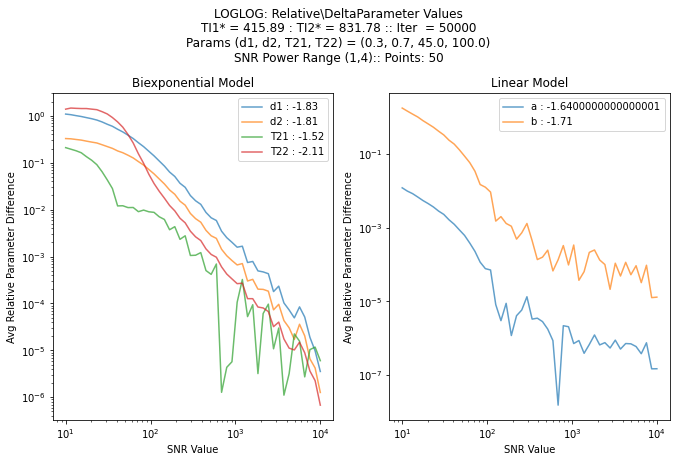

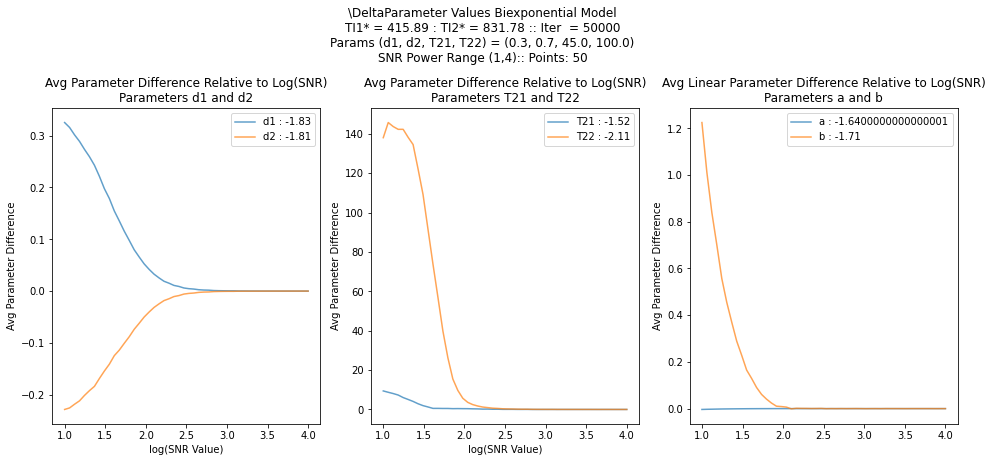

In [ ]:
#Compare difference in parameters

paramDiff_Sig = np.mean(paramStore_2E, axis = 1) - realParams #average along the iteration direction
paramDiff_Lin = np.mean(paramStore_lin, axis = 1) - linParams

order_Sig = np.mean(np.diff(np.log10(np.abs(paramDiff_Sig)), axis = 0)/np.reshape(np.diff(np.log10(SNR_array)),(-1,1)), axis = 0)//0.01*0.01
order_Lin = np.mean(np.diff(np.log10(np.abs(paramDiff_Lin)), axis = 0)/np.reshape(np.diff(np.log10(SNR_array)),(-1,1)), axis = 0)//0.01*0.01

#relative parameter difference
rpD_Sig = paramDiff_Sig/realParams
rpD_Lin = paramDiff_Lin/linParams

fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
fig.suptitle("LOGLOG:" + r'\Delta' + 'Parameter Values Biexponential Model' + details)
for i in range(2):
    ax[i].loglog(SNR_array,np.abs(paramDiff_Sig[:,2*i]), label = ParamTitle_4p[2*i] + " : " + str(order_Sig[2*i]), alpha = 0.7)
    ax[i].loglog(SNR_array,np.abs(paramDiff_Sig[:,2*i+1]), label = ParamTitle_4p[2*i+1] + " : " + str(order_Sig[2*i+1]), alpha = 0.7)
    ax[i].set_xlabel('SNR Value')
    ax[i].set_ylabel('Avg Parameter Difference')
    ax[i].set_title('Avg Loglog Parameter Difference Relative to SNR' +
                        '\nParameters ' + ParamTitle_4p[2*i] + ' and ' + ParamTitle_4p[2*i+1])
    ax[i].legend()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
fig.suptitle('LOGLOG: Relative' + r'\Delta' + 'Parameter Values' + details)
for i in range(np.size(ParamTitle_4p)):
    ax[0].loglog(SNR_array,np.abs(rpD_Sig[:,i]), label = ParamTitle_4p[i] + " : " + str(order_Sig[i]), alpha = 0.7)
ax[0].set_xlabel('SNR Value')
ax[0].set_ylabel('Avg Relative Parameter Difference')
ax[0].set_title('Biexponential Model')
ax[0].legend()

for i in range(np.size(LinTitle)):
    ax[1].loglog(SNR_array,np.abs(rpD_Lin[:,i]), label = LinTitle[i] + " : " + str(order_Lin[i]), alpha = 0.7)
ax[1].set_xlabel('SNR Value')
ax[1].set_ylabel('Avg Relative Parameter Difference')
ax[1].set_title('Linear Model')
ax[1].legend()
plt.show()


fig, ax = plt.subplots(1,3, figsize=(13.5,6.5), tight_layout=True)
fig.suptitle(r'\Delta' + 'Parameter Values Biexponential Model' + details)
for i in range(2):
    ax[i].plot(np.log10(SNR_array), paramDiff_Sig[:,2*i], label = ParamTitle_4p[2*i] + " : " + str(order_Sig[2*i]), alpha = 0.7)
    ax[i].plot(np.log10(SNR_array), paramDiff_Sig[:,2*i+1], label = ParamTitle_4p[2*i+1] + " : " + str(order_Sig[2*i+1]), alpha = 0.7)
    ax[i].set_xlabel('log(SNR Value)')
    ax[i].set_ylabel('Avg Parameter Difference')
    ax[i].set_title('Avg Parameter Difference Relative to Log(SNR)' +
                        '\nParameters ' + ParamTitle_4p[2*i] + ' and ' + ParamTitle_4p[2*i+1])
    ax[i].legend()

for i in range(2):
    ax[2].plot(np.log10(SNR_array), paramDiff_Lin[:,i], label = LinTitle[i] + " : " + str(order_Lin[i]), alpha = 0.7)
ax[2].set_ylabel('Avg Parameter Difference')
ax[2].set_title('Avg Linear Parameter Difference Relative to Log(SNR)' +
                    '\nParameters ' + LinTitle[0] + ' and ' + LinTitle[1])
ax[2].legend()

plt.show()


### Error Related Plots

##### Rules Broken

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


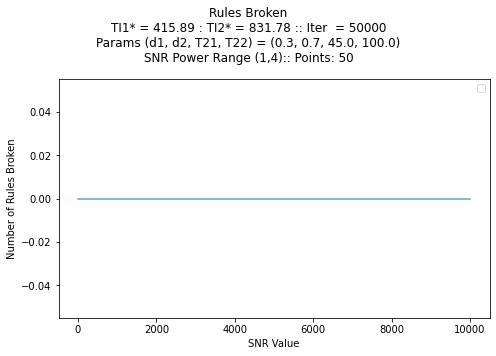

In [ ]:
fig = plt.figure(figsize=(7,5), tight_layout=True)
fig.suptitle('Rules Broken' + details)
plt.plot(SNR_array, numRuleBreak, alpha = 0.7)
plt.xlabel('SNR Value')
plt.ylabel('Number of Rules Broken')
# plt.title('Biexponential Model')
plt.legend()